<a href="https://colab.research.google.com/github/vamsikrishna00466/time_series/blob/main/Spare_parts_demand_forecasting_with_ML_Project_V_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preprocessing

In [ ]:
pip install auto-sklearn

In [ ]:
# print autosklearn version
import autosklearn
print('autosklearn: %s' % autosklearn.__version__)

autosklearn: 0.14.3


In [ ]:
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  import datetime
  pd.set_option('display.max_columns', 20)
  import warnings
  warnings.filterwarnings('ignore')
  

  path='/content/drive/MyDrive/SCA Projects/Forecasting /DFP11.01.2022.xlsx'

In [ ]:
class spare_parts_analysis:
  #importing Necessary Librarie
  def __init__(self, path):
    self.path = path

  def raw_data_cleaning(self,path):
    #importing data
    print('collecting data....')
    df= pd.read_excel(path)
    print('Data collection completed')
    #droping unecessary cloumns by client guidence
    print('\nData clening in processing...')
    droping_columns = df.loc[:, datetime.datetime(2017, 12, 1, 0, 0): 'Total'].columns.to_list()
    df1 = df.copy()
    del df1['Total.1']
    for i in droping_columns:
      del df1[i]
    #converting date columns into rows
    df2 = df1.melt(id_vars=["Part No. D", "NDP",'Category','MOQ','Opening Stock'],
                   var_name="Month",value_name="demand")
    #HAndling missing values
    df2['demand'] = df2['demand'].fillna(0)
    df2['Opening Stock'] = df2['Opening Stock'].fillna(0)
    df2['Part No. D'] = df2['Part No. D'].fillna('Missing_sku')
    df2 = df2[df2['Part No. D']!='Missing_sku'].reset_index(drop=bool)
    df2['Month'] = pd.to_datetime(df2['Month'])
    #dulpicates removing
    df2 = df2.groupby(by=['Month','Part No. D']).agg({'demand':'first',
                                                      'Category':'first',
                                                      'Opening Stock':'first',
                                                      'MOQ':'first',
                                                      'NDP':'first',
                                                      }).reset_index()
    print('Data clened')
    return df2
  
  def data_manuplulation_from_raw_data(self,path,m):
    df1 = self.raw_data_cleaning(path)
    p = round(m/df1['Month'].nunique(),2)*100
    #Sku And Category adding
    print(f'\nmore than {m} months no sales skus removing...')
    df1['sku'] = df1['Part No. D']+'_'+df1['Category']
    ##converting categories into columns
    df2 = df1.pivot(index=['Month'], columns='sku', values='demand')
    for i in df2.columns:
      Zeros = round((len(df2[df2[i]==0])/len(df2))*100,3)
      if Zeros>p:
        del df2[i]
    print(f'more than {m} months no sales skus removed\n')
    return df2
  
  #converting timeseries problem to supervised machinelearing problem
  def time_series_to_SML(self,path,m):

    df=self.data_manuplulation_from_raw_data(path,m)
    print('\nInitial data preprocessing completed\n')
    print('\nTime series to supervised Ml conversion processing....\n')
    df_lag= df.copy()
    #Lag values calculating
    for i in df.columns:
      for lag in [1,2,3,4,5,6]:
        df_lag[str(i)+'_lag_'+str(lag)] = df_lag[i].shift(lag)
    
    #removing nan values(lag)
    df1 = df.iloc[6:]
    df_lag1 = df_lag.iloc[6:]
      
    #transfering columns to rowws
    df1 = df1.reset_index()
    df1 = df1.melt(id_vars=['Month'],
                   var_name="SKU",value_name="demand")
      
    df_lag1 = df_lag1.reset_index()
    df_lag1 = df_lag1.melt(id_vars=['Month'],
                            var_name="SKU",value_name="demand")
    #Lag values seperating
    df_lag1['lag'] = df_lag1['SKU'].str[-5:-2]
    lag = df_lag1[df_lag1['lag']=='lag'].reset_index(drop=bool)
      
    df_lag11 = df_lag1[df_lag1['lag']!='lag'].reset_index(drop=bool)
    
    lag['lag_value']=lag['SKU'].str[-1:]
    lag['lag_value'] = lag['lag_value'].astype(int)

    del lag['lag']

    on = lag[lag['lag_value']==1]
    tw = lag[lag['lag_value']==2]
    th = lag[lag['lag_value']==3]
    fo = lag[lag['lag_value']==4]
    fi = lag[lag['lag_value']==5]
    si = lag[lag['lag_value']==6]
    

    on = on.rename({'demand':'lag1'}, axis=1)
    tw = tw.rename({'demand':'lag2'}, axis=1)
    th = th.rename({'demand':'lag3'}, axis=1)
    fo = fo.rename({'demand':'lag4'}, axis=1)
    fi = fi.rename({'demand':'lag5'}, axis=1)
    si = si.rename({'demand':'lag6'}, axis=1)
    
    del on['lag_value']
    del tw['lag_value']
    del th['lag_value']
    del fo['lag_value']
    del fi['lag_value']
    del si['lag_value']

    on['SKU'] = on['SKU'].str[:-6]
    tw['SKU'] = tw['SKU'].str[:-6]
    th['SKU'] = th['SKU'].str[:-6]
    fo['SKU'] = fo['SKU'].str[:-6]
    fi['SKU'] = fi['SKU'].str[:-6]
    si['SKU'] = si['SKU'].str[:-6]
      
    lag_all = pd.merge(on,tw, on=['Month','SKU'])
    lag_all = pd.merge(lag_all,th, on=['Month','SKU'])
    lag_all = pd.merge(lag_all,fo, on=['Month','SKU'])
    lag_all = pd.merge(lag_all,fi, on=['Month','SKU'])
    lag_all = pd.merge(lag_all,si, on=['Month','SKU'])
     
    df_final = pd.merge(df1,lag_all, on=['Month','SKU'])
    print('\nTime series to supervised Ml conversion completed\n')
    return df,df_final

In [ ]:
import time
start = time.time()

sku_analysis = spare_parts_analysis(path)

df,df_processed = sku_analysis.time_series_to_SML(path,m=1)

#df = sku_analysis.data_manuplulation_from_raw_data(path,m=1)

end = time.time()
print('Exicution time',round((end - start)/60,3),'Minutes')

collecting data....
Data collection completed

Data clening in processing...
Data clened

more than 1 months no sales skus removing...
more than 1 months no sales skus removed


Initial data preprocessing completed


Time series to supervised Ml conversion processing....


Time series to supervised Ml conversion completed

Exicution time 1.556 Minutes


In [ ]:
df_final = df_processed.copy()

In [ ]:
#lable enconding of skus
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(df_final['SKU'])

df_final['SKU'] = le.transform(df_final['SKU'])
#df_final['SKU'] = le.inverse_transform(df_final['SKU'])#for getting actual sku's

df_final['year'] = pd.DatetimeIndex(df_final['Month']).year
df_final['month'] = pd.DatetimeIndex(df_final['Month']).month

del df_final['Month']

df_final = df_final.sort_values(by=['year','month','SKU']).reset_index(drop=bool)

X = df_final.copy()#predictors
del X['demand']
y=df_final['demand']#target variable


In [ ]:
df_final

,SKU,demand,lag1,lag2,lag3,lag4,lag5,lag6,year,month
0,0,772.0,450.0,285.0,590.0,300.0,465.0,660.0,2018,6
1,1,1235.0,295.0,875.0,1180.0,950.0,1015.0,1551.0,2018,6
2,2,510.0,181.0,208.0,175.0,290.0,95.0,204.0,2018,6
3,3,670.0,455.0,280.0,225.0,245.0,250.0,432.0,2018,6
4,4,117.0,169.0,106.0,191.0,100.0,128.0,146.0,2018,6
...,...,...,...,...,...,...,...,...,...,...
19603,451,57.0,61.0,37.0,83.0,34.0,32.0,78.0,2021,12
19604,452,58.0,28.0,30.0,16.0,16.0,29.0,55.0,2021,12
19605,453,375.0,306.0,323.0,260.0,180.0,108.0,191.0,2021,12
19606,454,450.0,421.0,387.0,365.0,287.0,262.0,371.0,2021,12


In [ ]:
y

0         772.0
1        1235.0
2         510.0
3         670.0
4         117.0
          ...  
19603      57.0
19604      58.0
19605     375.0
19606     450.0
19607     448.0
Name: demand, Length: 19608, dtype: float64

## Train Test Split

In [ ]:
#creating the train and Test set
X_train = X[:int(0.8*(len(X)))]
y_train = y[:int(0.8*(len(X)))]

X_test = X[int(0.8*(len(X))):]
y_test = y[int(0.8*(len(X))):]

## Auto ML

In [ ]:
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_absolute_error as auto_mean_absolute_error
from sklearn.metrics import mean_absolute_error


In [ ]:
import time
start = time.time()

# define search
model = AutoSklearnRegressor(time_left_for_this_task=5*60,
                             per_run_time_limit=30, n_jobs=8)

# perform the search
model.fit(X_train, y_train)

# summarize
print(model.sprint_statistics())

# evaluate best model
y_hat = model.predict(X_test)

#Error calculation
from sklearn.metrics import mean_squared_error
rmse = round(np.sqrt(mean_squared_error(y_test, y_hat, squared=False)),3)##rmse calculation
print("RMSE: %.3f" % rmse)
print('\n')

from sklearn.metrics import mean_absolute_percentage_error
mape = round(mean_absolute_percentage_error(y_test, y_hat),3)##mape calculation
print("MAPE: %.3f" % mape)


end = time.time()
print('\nExicution time',round((end - start)/60,3),'Minutes')

auto-sklearn results:
  Dataset name: 96ba17c8-7b3c-11ec-8124-0242ac1c0002
  Metric: r2
  Best validation score: 0.801546
  Number of target algorithm runs: 53
  Number of successful target algorithm runs: 28
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 20
  Number of target algorithms that exceeded the memory limit: 4

RMSE: 23.792


MAPE: 1.012

Exicution time 5.053 Minutes


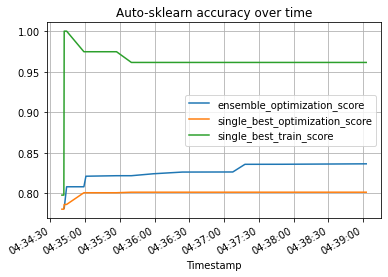

In [ ]:
model.performance_over_time_.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)
plt.show()

In [ ]:
model.show_models()

"[(0.260000, SimpleRegressionPipeline({'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'k_nearest_neighbors', 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'quantile_transformer', 'regressor:k_nearest_neighbors:n_neighbors': 1, 'regressor:k_nearest_neighbors:p': 1, 'regressor:k_nearest_neighbors:weights': 'uniform', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.000150707968821655, 'data_preprocessor:feature_type:numerical_transformer:rescaling:quantile_transformer:n_quantiles': 1081, 'data_preprocessor:feature_type:

In [ ]:
model.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
22,1,0.12,gradient_boosting,0.198454,13.336583
11,2,0.16,gradient_boosting,0.199107,17.489598
49,3,0.14,adaboost,0.199341,24.635794
29,4,0.20,decision_tree,0.209577,2.418067
8,5,0.12,k_nearest_neighbors,0.213537,8.880828
38,6,0.26,k_nearest_neighbors,0.261854,3.958708


## XG Boost Hyperparameter Tuning

In [ ]:
## Hyper Parameter Optimization

n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }


In [ ]:
import xgboost
regressor=xgboost.XGBRegressor()

from sklearn.model_selection import RandomizedSearchCV


In [ ]:
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [ ]:
import time
start = time.time()

random_cv.fit(X_train,y_train)

end = time.time()
print('Exicution time',round((end - start)/60,3),'Minutes')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[05:04:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Exicution time 24.873 Minutes


In [ ]:
random_cv.best_estimator_


XGBRegressor(base_score=1, booster='gblinear', learning_rate=0.05, max_depth=15,
             min_child_weight=4)

## XGB testing with optimized parameters

In [ ]:
import time
start = time.time()

#xgbr=xgboost.XGBRegressor(base_score=1, booster='gblinear', learning_rate=0.05, max_depth=15,
#             min_child_weight=4)
xgbr=xgboost.XGBRegressor()
xgbr.fit(X_train, y_train)
print('XGB - Regression score:',xgbr.score(X, y))

end = time.time()
print('\nExicution time',round((end - start)/60,3),'Minutes')

[05:11:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB - Regression score: 0.8795079024501057

Exicution time 0.013 Minutes


In [ ]:
#testing
y_hat = xgbr.predict(X_test)

from sklearn.metrics import mean_squared_error

rmse = round(np.sqrt(mean_squared_error(y_test, y_hat, squared=False)),3)##rmse calculation
print("RMSE: %.3f" % rmse)
print('\n')
from sklearn.metrics import mean_absolute_percentage_error
mape = round(mean_absolute_percentage_error(y_test, y_hat),3)##mape calculation
print("MAPE: %.3f" % mape)

RMSE: 23.869


MAPE: 1.666


## Forecasting

In [ ]:
#Training with Whole data
import time
start = time.time()

xgbr=xgboost.XGBRegressor(base_score=0.75, max_depth=5, min_child_weight=2,
                               n_estimators=1100)
xgbr.fit(X, y)
print('XGB - Regression score:',xgbr.score(X, y))

end = time.time()
print('\nExicution time',round((end - start)/60,3),'Minutes')

[05:04:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB - Regression score: 0.9929805652817465

Exicution time 0.282 Minutes


In [ ]:
def forecat(X,p):
  f = X[-(X['SKU'].nunique()):].reset_index(drop=bool)
  
  for i in range(len(f)):
    if f['month'][i]==12:
      f['year'][i] = f['year'][i]+1
      f['month'][i] = 1
    elif f['month'][i]<12:
      f['month'][i] = f['month'][i]+1
    
  f['lag6'] = f['lag5']
  f['lag5'] = f['lag4']
  f['lag4'] = f['lag3']
  f['lag3'] = f['lag2']
  f['lag2'] = f['lag1']
  f['lag1'] = p[0]
  return f

In [ ]:
#1month forecasting
p = pd.DataFrame(xgbr.predict(X[-(X['SKU'].nunique()):]))
p

,0
0,509.190125
1,745.990051
2,131.878693
3,389.085693
4,139.577850
...,...
451,69.368896
452,43.492748
453,303.316681
454,359.649445


In [ ]:
#features for 1month forecast
f=forecat(X,p)
f

,SKU,lag1,lag2,lag3,lag4,lag5,lag6,year,month
0,0,509.190125,360.0,290.0,430.0,285.0,505.0,2022,1
1,1,745.990051,860.0,440.0,466.0,575.0,585.0,2022,1
2,2,131.878693,112.0,120.0,185.0,93.0,98.0,2022,1
3,3,389.085693,360.0,216.0,306.0,235.0,340.0,2022,1
4,4,139.577850,89.0,140.0,95.0,79.0,202.0,2022,1
...,...,...,...,...,...,...,...,...,...
451,451,69.368896,61.0,37.0,83.0,34.0,32.0,2022,1
452,452,43.492748,28.0,30.0,16.0,16.0,29.0,2022,1
453,453,303.316681,306.0,323.0,260.0,180.0,108.0,2022,1
454,454,359.649445,421.0,387.0,365.0,287.0,262.0,2022,1


In [ ]:
#2month forecasting
p = pd.DataFrame(xgbr.predict(f))
p

,0
0,310.038147
1,570.272095
2,105.200356
3,242.306641
4,110.308838
...,...
451,35.352749
452,8.723503
453,244.214081
454,312.976288


In [ ]:
#features for 1month forecast
f=forecat(f,p)
f

,SKU,lag1,lag2,lag3,lag4,lag5,lag6,year,month
0,0,310.038147,509.190125,360.0,290.0,430.0,285.0,2022,2
1,1,570.272095,745.990051,860.0,440.0,466.0,575.0,2022,2
2,2,105.200356,131.878693,112.0,120.0,185.0,93.0,2022,2
3,3,242.306641,389.085693,360.0,216.0,306.0,235.0,2022,2
4,4,110.308838,139.577850,89.0,140.0,95.0,79.0,2022,2
...,...,...,...,...,...,...,...,...,...
451,451,35.352749,69.368896,61.0,37.0,83.0,34.0,2022,2
452,452,8.723503,43.492748,28.0,30.0,16.0,16.0,2022,2
453,453,244.214081,303.316681,306.0,323.0,260.0,180.0,2022,2
454,454,312.976288,359.649445,421.0,387.0,365.0,287.0,2022,2


In [ ]:
#2month forecasting
p = pd.DataFrame(xgbr.predict(f))
p

,0
0,401.912140
1,500.654053
2,97.944550
3,322.488159
4,98.841835
...,...
451,52.486595
452,24.141390
453,225.599564
454,265.695282


In [ ]:
#3,4,...monthns to forecast
f=forecat(f,p)
p = pd.DataFrame(xgbr.predict(f))
p

,0
0,322.237885
1,561.297852
2,92.038300
3,245.814423
4,90.496223
...,...
451,43.656063
452,26.530878
453,188.031387
454,304.089264


## Custamized forecasting

In [ ]:
month=10#Number of months to do forecasting

p = pd.DataFrame(xgbr.predict(X[-(X['SKU'].nunique()):]))
#for future 1month forecast
f=forecat(X,p)

n=0
for i in range(1,month):
  f=forecat(f,p)
  p = pd.DataFrame(xgbr.predict(f))
  if n==0:
    forecasted_results = pd.DataFrame(xgbr.predict(f))
  else:
    forecasted_results = pd.concat([forecasted_results,p],axis=1)
  n+=1

forecasted_results = round(forecasted_results)
forecasted_results['SKU'] = f['SKU']
forecasted_results['SKU'] = le.inverse_transform(forecasted_results['SKU'])


In [37]:
forecasted_results.columns = ['m1','m2','m3','m4','m5','m6','m7','m8','m9','SKU']

In [57]:
for i in ['m1','m2','m3','m4','m5','m6','m7','m8','m9']:
  for j in range(len(forecasted_results)):
    if forecasted_results[i][j]<0:
      forecasted_results[i][j]=0


## Saving Model into pickle formate

In [64]:
# loading library
import pickle


##wb --writing in binary mode
## saving model into default folder
'''rb : Opens the file as read-only
in binary format and starts reading from the beginning of the file'''
pickle.dump(xgbr, open('model_pkl', 'wb'))



In [65]:
# loading library
import pickle



model1 = pickle.load(open('/content/model_pkl', 'rb'))


[08:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [66]:
month=10#Number of months to do forecasting

p = pd.DataFrame(model1.predict(X[-(X['SKU'].nunique()):]))
#for future 1month forecast
f=forecat(X,p)

n=0
for i in range(1,month):
  f=forecat(f,p)
  p = pd.DataFrame(model1.predict(f))
  if n==0:
    forecasted_results = pd.DataFrame(model1.predict(f))
  else:
    forecasted_results = pd.concat([forecasted_results,p],axis=1)
  n+=1

forecasted_results = round(forecasted_results)
forecasted_results['SKU'] = f['SKU']
forecasted_results['SKU'] = le.inverse_transform(forecasted_results['SKU'])


In [67]:
forecasted_results

,0,0,0,0,0,0,0,0,0,SKU
0,345.0,343.0,376.0,520.0,594.0,560.0,508.0,551.0,562.0,A0002_Regular
1,452.0,525.0,564.0,862.0,979.0,975.0,869.0,928.0,1041.0,A0006_Regular
2,121.0,104.0,93.0,194.0,248.0,223.0,244.0,253.0,263.0,A0007_Regular
3,306.0,297.0,313.0,483.0,552.0,460.0,487.0,530.0,526.0,A0008_Regular
4,102.0,107.0,93.0,194.0,248.0,223.0,244.0,253.0,263.0,A0010_Regular
...,...,...,...,...,...,...,...,...,...,...
451,52.0,75.0,59.0,152.0,208.0,198.0,180.0,202.0,221.0,P0700_Regular
452,48.0,47.0,54.0,137.0,181.0,153.0,169.0,197.0,221.0,P0720_Regular
453,233.0,215.0,195.0,335.0,426.0,379.0,373.0,424.0,449.0,P0729_Kit-Child Part
454,350.0,384.0,384.0,520.0,605.0,575.0,551.0,551.0,562.0,P0730_Kit-Child Part
